---

title: "Analysis of Banfield Tree of life"

author: Benjamin Doran

date: today

---

## Setup

In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

using SPI, StatsBase
using FASTX, CSV, DataFrames
using NewickTree, NewickTreeTools
using StatsPlots

include(srcdir("helpers.jl"))
include(srcdir("neighborjoining.jl"))

using BioServices.EUtils, EzXML

In [2]:
rdir = datadir("exp_pro", "banfield_etal_data")
pdir = plotsdir("banfieldtree_analysis") |> mkpath
mdir = joinpath(rdir, "MIscores") |> mkpath
sdir = joinpath(rdir, "subset_data") |> mkpath

"/Users/ben/projects/Doran_etal_2022/data/exp_pro/banfield_etal_data/subset_data"

## Data Cleaning

Collect all bacterial taxa that have at least partial lineage information and are matched between the tree of life and the alignment file

In [3]:
adf = readfasta(joinpath(rdir, "alignment.fa"));
size(adf)

(3083, 3)

In [ ]:
# banfieldtreestring = readline(joinpath(rdir, "treeoflife.nw"));
# banfieldtreestring_processed = replace(
#     banfieldtreestring,
#     r"(?<=\)):([\d.E\-]*)(\[)(\d*)(\])"=>s"\3.0:\1",
# )
# open(joinpath(rdir, "treeoflife_processed.nw"), "w") do io
#     println(io, banfieldtreestring_processed)
# end
banfieldtreestring_processed = open(readline, joinpath(rdir, "treeoflife_processed.nw"))
banfieldtree = readnw(banfieldtreestring_processed);

In [ ]:
# banfieldbacteriatree = collectiveLCA(leaves[isbacteria]);
filtered_tree = getleafnames(banfieldtree) |>
    x->startswith.(x, "Bacteria") |>
    x->getleaves(banfieldtree)[x] |>
    collectiveLCA |>
    NewickTree.nwstr |>
    readnw;

In [ ]:
# fullyfilteredtree = getleafnames(filtered_tree) |>
#     x->indexin(x, adf.label) |>
#     x->getleafnames(filtered_tree)[.!isnothing.(x)] |>
#     x->NewickTree.extract(filtered_tree, x);

In [ ]:
# open(joinpath(rdir, "filtered_banfield_tree.nw"), "w") do io
#     println(io, fullyfilteredtree)
# end
fullyfilteredtree = readnw(open(readline, joinpath(rdir, "filtered_banfield_tree.nw")));

In [ ]:
leafnames = getleafnames(fullyfilteredtree);
accdf = CSV.read(joinpath(rdir, "accessions.tsv"), DataFrame, header=1, delim="\t", comment="#");
accdf = accdf[filter(!isnothing, indexin(accdf.ORGANISM, leafnames)), :] |>
    df -> filter(:NCBI_GENOME_ACCESSION => !ismissing, df);

In [ ]:
CSV.write(joinpath(rdir, "accessions_filt.csv"), accdf)

In [ ]:
# ## Collect Tax IDs from taxa based on sample accession ids

# biosample_idx = contains.(accdf.NCBI_GENOME_ACCESSION, r"^SAM")
# nucleotide_idx = contains.(accdf.NCBI_GENOME_ACCESSION, r"^N[A-Z]_");
# tmp_tax_id = repeat([""], nrow(accdf));

# ## Add biosampled taxids...
# res = efetch(db="biosample", id=accdf.NCBI_GENOME_ACCESSION[biosample_idx], retmode="xml");
# doc = parsexml(res.body)
# tmp_tax_id[biosample_idx] .= map(findall("//Organism", root(doc))) do n
#     n["taxonomy_id"]
# end;

# ## add Nucleotide taxids by first mapping to biosample ids
# res = efetch(db="genome", id=accdf.NCBI_GENOME_ACCESSION[nucleotide_idx], retmode="xml");
# doc = parsexml(res.body)
# EzXML.write(joinpath(rdir, "nucleotide_response.xml"), doc)
# # doc = parsexml(EzXML.read(joinpath(rdir, "nucleotide_response.xml")));
# NucIDtoSMPID = map(eachelement(root(doc))) do seqref
#     acc = findall(".//GBSeq_primary-accession", seqref) |>
#         x->nodecontent.(x)

#     smpid = findall(".//GBXref/GBXref_dbname[.='BioSample']/following-sibling::node()", seqref) |>
#         x->nodecontent.(x)
#     smpid = length(smpid) > 1 ? smpid[2] : nothing

#     acc[1], smpid
# end;
# locatedSMPIDs = .∈(accdf.NCBI_GENOME_ACCESSION, Ref(first.(filter(t -> !isnothing(last(t)), NucIDtoSMPID))))
# SMPIDvec = repeat([""], nrow(accdf))
# SMPIDvec[locatedSMPIDs] .= last.(filter(t -> !isnothing(last(t)), NucIDtoSMPID));
# res_1 = efetch(db="biosample", id=last.(filter(t -> !isnothing(last(t)), NucIDtoSMPID)), retmode="xml");
# doc_1 = parsexml(res_1.body);
# more_tax_ids = map(eachelement(root(doc_1))) do n
#     acc = n["accession"]
#     taxid = findfirst(".//Organism", n) |>
#         x-> haskey(x, "taxonomy_id") ? x["taxonomy_id"] : nothing
#     acc, taxid
# end;
# tmp_tax_id[.∈(SMPIDvec, Ref(first.(more_tax_ids)))] .= last.(more_tax_ids)[.∈(first.(more_tax_ids), Ref(SMPIDvec))]
# accdf[!, "tax_id"] = replace(tmp_tax_id, ""=>missing)

In [ ]:
CSV.write(joinpath(rdir, "accessions_filt.csv"), accdf)

In [ ]:
accdf = CSV.read(joinpath(rdir, "accessions_filt.csv"), DataFrame);

In [ ]:
taxids = join(string.(filter(!ismissing, accdf.tax_id)), "\n")
lineagedf = pipeline(
    `echo $taxids`,
    `cat`,
    `taxonkit lineage`,
    `taxonkit reformat`
) |> read |> x->CSV.read(x, DataFrame, header=["tax_id", "lineage", "formatted_lineage"]);

In [ ]:
CSV.write(joinpath(rdir, "lineagedf.tsv"), lineagedf, delim="\t")

In [ ]:
nrow(lineagedf)

In [ ]:
findall(ismissing, lineagedf.formatted_lineage)

In [ ]:
splitlineagedf = lineagedf |>
    df->filter(:formatted_lineage => !ismissing, df) |>
    df->DataFrames.transform(df,
        :formatted_lineage => ByRow(x->split(x, ";")) => ["kingdom", "phylum", "class", "order", "family", "genus", "species"],
    );

In [ ]:
leftjoin(accdf, splitlineagedf, on = :tax_id, matchmissing=:notequal) |>
    df->filter(:lineage=>!ismissing, df) |>
    df->CSV.write(joinpath(rdir, "filtered_linage.csv"), df)

In [ ]:
filtered_lineagedf = CSV.read(joinpath(rdir, "filtered_linage.csv"), DataFrame);

In [ ]:
filtered_lineagedf[:, ["ORGANISM", "kingdom", "phylum", "class", "order", "family", "genus", "species"]]

In [ ]:
map(["kingdom", "phylum", "class", "order", "family", "genus", "species"]) do colname
    colname, mean(.!ismissing.(filtered_lineagedf[!, colname]))
end

In [ ]:
matchedlabels = intersect(adf.label, getleafnames(banfieldtree), filtered_lineagedf.ORGANISM);
size(matchedlabels)

### Write out clean data

In [ ]:
subset_banfieldtree = NewickTree.extract(banfieldtree, matchedlabels);
open(joinpath(sdir, "subset_banfieldtree.nw"), "w") do io
    println(io, NewickTree.nwstr(subset_banfieldtree))
end

In [ ]:
adf[in.(adf.label, Ref(matchedlabels)), :] |>
    df -> CSV.write(joinpath(sdir, "subset_alignment.csv"), df)

In [ ]:
filtered_lineagedf[in.(filtered_lineagedf.ORGANISM, Ref(matchedlabels)), :] |>
    df -> CSV.write(joinpath(sdir, "subset_lineage.csv"), df)

## Start analyzing tree

In [3]:
banfieldtree = readnw(open(readline, joinpath(sdir, "subset_banfieldtree.nw")))
adf = CSV.read(joinpath(sdir, "subset_alignment.csv"), DataFrame)
lineagedf = CSV.read(joinpath(sdir, "subset_lineage.csv"), DataFrame);

In [6]:
2279 / length(unique(lineagedf.species))

1.0169567157518964

In [12]:
adf.label
(adf.label .== permutedims(adf.label))[triu(trues(2250, 2250),1)] |> sum #???

0

In [9]:
(lineagedf.species .== permutedims(lineagedf.species))[triu(trues(2279, 2279),1)] |> sum #???

326

### Make SPI trees

In [ ]:
### Make SPI trees from alignment ###

binarymtx = onehotencode(adf.sequence)
usv = svd(Matrix(binarymtx));
spiDij = calc_spi_mtx(usv.U, usv.S, getintervals(usv.S)) / length(adf.sequence[1]);


hc = hclust(spiDij, linkage=:single, branchorder=:optimal)
spi_single_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
open(joinpath(sdir, "spitree.single.nw"), "w") do io
    println(io, spi_single_nwstring)
end

hc = hclust(spiDij, linkage=:complete, branchorder=:optimal)
spi_complete_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
open(joinpath(sdir, "spitree.complete.nw"), "w") do io
    println(io, spi_complete_nwstring)
end

hc = hclust(spiDij, linkage=:average, branchorder=:optimal)
spi_upgma_nwstring = SPI.nwstr(hc, adf.sample_id; labelinternalnodes=false)
open(joinpath(sdir, "spitree.upgma.nw"), "w") do io
    println(io, spi_upgma_nwstring)
end

NJmerges, NJheights = fastNJ(spiDij);
spi_nj_nwstring = newickstring(NJmerges, NJheights, adf.sample_id)
open(joinpath(sdir, "spitree.neighborjoined.nw"), "w") do io
    println(io, spi_nj_nwstring)
end

# CSV.write(joinpath(rdir, "alignment_tipmeta.csv"), adf[:, ["tip_ids", "label"]])
# tip_ids = ["Tip_$i" for i in 1:nrow(adf)];
# writephylip(joinpath(rdir, "spidist.phylip"), spiDij, tip_ids)

In [ ]:
getheights(readnw(spi_nj_nwstring)) |> histogram

In [ ]:
charmtx = SPI._stringcolumntocharmtx(adf.sequence);

In [ ]:
Nboot = 100
Nchars = length(adf.sequence[1])

spi_upgma_nw_bootstrings = []
spi_nj_nw_bootstrings = []
for i in 1:Nboot
    cols = sample(axes(charmtx,2), size(charmtx, 2), replace=true)
    binarymtx = onehotencode(charmtx[:, cols])
    usv = svd(Matrix(binarymtx));
    spiDij = calc_spi_mtx(usv.U, usv.S, getintervals(usv.S)) / Nchars;

    upgma_hc = hclust(spiDij, linkage=:single, branchorder=:optimal)
    push!(spi_upgma_nw_bootstrings, SPI.nwstr(upgma_hc, adf.sample_id; labelinternalnodes=false))

    NJmerges, NJheights = fastNJ(spiDij);
    spi_nj_boot_nwstring = newickstring(NJmerges, NJheights, adf.sample_id)
    push!(spi_nj_nw_bootstrings, spi_nj_boot_nwstring)
end

open(joinpath(sdir, "spitree.upgma.boottrees.nw"), "w") do io
    for btree in spi_upgma_nw_bootstrings
        println(io, btree)
    end
end

open(joinpath(sdir, "spitree.neighborjoined.boottrees.nw"), "w") do io
    for btree in spi_nj_nw_bootstrings
        println(io, btree)
    end
end

In [ ]:
using Gotree_jll

In [ ]:
reftreefile = joinpath(sdir, "spitree.upgma.nw")
boottreesfile = joinpath(sdir, "spitree.upgma.boottrees.nw")
outfile = joinpath(sdir, "spitree.upgma.supporttree.nw")
run(`$(gotree()) compute support booster -i $reftreefile -b $boottreesfile -o $outfile`)

In [ ]:
reftreefile = joinpath(sdir, "spitree.neighborjoined.nw")
boottreesfile = joinpath(sdir, "spitree.neighborjoined.boottrees.nw")
outfile = joinpath(sdir, "spitree.neighborjoined.supporttree.nw")
run(`$(gotree()) compute support booster -i $reftreefile -b $boottreesfile -o $outfile`)

### compare support values

In [5]:
spi_nj_tree = readnw(open(readline, joinpath(sdir, "spitree.neighborjoined.supporttree.nw")));
spi_upgma_tree = readnw(open(readline, joinpath(sdir, "spitree.upgma.supporttree.nw")));

In [6]:
supports, heights = mapinternalnodes(banfieldtree) do node
    NewickTree.support(node), NewickTree.height(node)
end |> ((x) -> (first.(x), last.(x)));

In [ ]:
plot(
    ylabel="support",
    xlabel="tree depth",
    label="internal node",
    # ylims=(-0.1,1.1),
    legend=:bottomleft,
)
scatter!(heights / maximum(heights), supports, label="Banfield tree")

In [ ]:
prop_nodesremaining = map(0:1:100) do s
    mean(supports .>= s)
end
plot(
    title="tree sparsity as function of node replicability",
    xlabel="tree support",
    ylabel="proportion of nodes remaining",
    ylims=(0,1),
    xticks=[0., .25, .5, .75, .9, 1.],
    yticks=round.(prop_nodesremaining[[26, 51, 76, 91, 101]], digits=2),
    legend=:bottomleft,
)
plot!(0:0.01:1, prop_nodesremaining, label="Banfield tree")

In [ ]:
supports, heights = mapinternalnodes(spi_upgma_tree) do node
    NewickTree.support(node), NewickTree.height(node)
end |> ((x) -> (first.(x), last.(x)));

In [ ]:
plot(
    ylabel="support",
    xlabel="tree depth",
    label="internal node",
    # ylims=(-0.1,1.1),
    legend=:bottomleft,
)
scatter!(heights / maximum(heights), supports, label="SPI UPGMA tree")

In [ ]:
prop_nodesremaining = map(0:0.01:1) do s
    mean(supports .>= s)
end
plot(
    title="tree sparsity as function of node replicability",
    xlabel="tree support",
    ylabel="proportion of nodes remaining",
    ylims=(0,1),
    xticks=[0., .25, .5, .75, .9, 1.],
    yticks=round.(prop_nodesremaining[[26, 51, 76, 91, 101]], digits=2),
    legend=:bottomleft,
)
plot!(0:0.01:1, prop_nodesremaining, label="SPI UPGMA tree")

In [ ]:
supports, heights = mapinternalnodes(spi_nj_tree) do node
    NewickTree.support(node), NewickTree.height(node)
end |> ((x) -> (first.(x), last.(x)));

In [ ]:
plot(
    ylabel="support",
    xlabel="tree depth",
    label="internal node",
    # ylims=(-0.1,1.1),
    legend=:bottomright,
)
scatter!(heights / maximum(heights), supports, label="SPI NJ tree")

In [ ]:
prop_nodesremaining = map(0:0.01:1) do s
    mean(supports .>= s)
end
plot(
    title="tree sparsity as function of node replicability",
    xlabel="tree support",
    ylabel="proportion of nodes remaining",
    ylims=(0,1),
    xticks=[0., .25, .5, .75, .9, 1.],
    yticks=round.(prop_nodesremaining[[26, 51, 76, 91, 101]], digits=2),
    legend=:bottomleft,
)
plot!(0:0.01:1, prop_nodesremaining, label="SPI NJ tree")

### Calculate MI curves

In [ ]:
NCUTS = 100
NPERMS = 5

function clusters_per_cutlevel(distfun::Function, tree::Node, ncuts::Number)
    minmax = extrema(mapinternalnodes(distfun, tree, tree))
    cuts = range(0, minmax[2], length=ncuts)
    clusts = [cuttree(distfun, tree, cut) for cut in cuts]
    clustmappings = map(c->getleafnames.(c), clusts)
    clustersmps = [vcat(clustmapping...) for clustmapping in clustmappings]
    clusterids = [Int.(vcat([zeros(length(c)) .+ j for (j, c) in enumerate(clustmapping)]...)) for clustmapping in clustmappings];
    return clusterids, clustersmps
end

function pairedMIagainstmetacolumn(metacolumns, IDS, clusterids, clustersmps; bootstrap=false, mask=nothing)
    tstat_MI = zeros(length(clusterids), size(metacolumns, 2))
    for (i, mcol) in enumerate(eachcol(metacolumns))
        # cat = levelorder(categorical(mcol))
        # pcat = cat .== cat'
        pcat = mcol .== permutedims(replace(mcol, ""=>"missing"))
        tstat_MI[:, i] .= collectMI_across_treedepth(clusterids, clustersmps, IDS, pcat; bootstrap, mask)
    end
    DataFrame(tstat_MI, names(metacolumns)) |> stack |> df->rename!(df,["taxaID","MI"]);
end

function collectMI_across_treedepth(clusterids, clustersmps, IDS, ptax; bootstrap=false, mask=nothing)
    uppertriangle = triu(trues(size(ptax)), 1);
    uppertriangle = isnothing(mask) ? uppertriangle : uppertriangle[mask, mask]
    # ptax = if isnothing(mask) ptax[uppertriangle] else ptax[mask, mask][uppertriangle] end
    map(clusterids, clustersmps) do cids, smps; ptax, IDS, mask
        clustorder = indexin(IDS, smps)
        pcids = cids[clustorder] .== cids[clustorder]'
        pcids = if isnothing(mask) pcids else pcids[mask, mask] end
        wptax = if isnothing(mask) ptax else ptax[mask, mask] end
        pcids = pcids[uppertriangle]
        wptax = wptax[uppertriangle]
        if bootstrap
            vals_idx = sample(axes(pcids, 1), length(pcids), replace=true)
            pcids = pcids[vals_idx]
            wptax = wptax[vals_idx]
        end
        empiricalMI(wptax, pcids)
    end
end

In [ ]:
NBOOT = 50

In [ ]:
taxonomylevels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
lineageroworder = indexin(adf.label, lineagedf.ORGANISM)
rowmeta = lineagedf[lineageroworder, taxonomylevels]
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
IDS = lineagedf.ORGANISM[lineageroworder]
for col in eachcol(rowmeta)
    replace!(col, missing=>"")
end

In [ ]:
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [ ]:
spi_upgma_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_upgma_tree)

@info "calculate tree cuts for SPI tree..."
@time clusterids, clustersmps = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_upgma_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spiMI_upgma_df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spiupgma_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids, clustersmps; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spiMI_upgma_df[!, :MI_boot_mean] = vec(mean(spiupgma_bootstrappedMIs, dims=2))
spiMI_upgma_df[!, :MI_boot_std] = vec(std(spiupgma_bootstrappedMIs, dims=2));
spiMI_upgma__bootstraps_df = DataFrame(spiupgma_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spiupgma_bootstrappedMIs, 2)]);
SPIupgma_pltdf = hcat(spiMI_upgma_df, spiMI_upgma__bootstraps_df);
boot_SPIupgma_pltdf = SPIupgma_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

In [ ]:
CSV.write(joinpath(mdir, "spi_upgma_MI.csv"), spiMI_upgma_df)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps.csv"), SPIupgma_pltdf)
CSV.write(joinpath(mdir, "spi_upgma_MI_bootstraps_aggregated.csv"), boot_SPIupgma_pltdf)

In [ ]:
spi_nj_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_nj_tree)

@info "calculate tree cuts for SPI tree..."
@time clusterids_nj, clustersmps_nj = clusters_per_cutlevel(NewickTreeTools.network_distance, spi_nj_tree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time spi_nj_MIdf = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time spinj_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_nj, clustersmps_nj; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
spi_nj_MIdf[!, :MI_boot_mean] = vec(mean(spinj_bootstrappedMIs, dims=2))
spi_nj_MIdf[!, :MI_boot_std] = vec(std(spinj_bootstrappedMIs, dims=2));
spiMI_nj__bootstraps_df = DataFrame(spinj_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(spinj_bootstrappedMIs, 2)]);
SPInj_pltdf = hcat(spi_nj_MIdf, spiMI_nj__bootstraps_df);
boot_SPInj_pltdf = SPInj_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

In [ ]:
CSV.write(joinpath(mdir, "spi_nj_MI.csv"), spi_nj_MIdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), SPInj_pltdf)
CSV.write(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), boot_SPInj_pltdf)

In [ ]:
banfieldtree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, banfieldtree)

@info "calculate tree cuts for SPI tree..."
@time clusterids_banfield, clustersmps_banfield = clusters_per_cutlevel(network_distance, banfieldtree_50pct, NCUTS);

@info "calculate test MI for SPI tree..."
@time banfieldMIdf = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_banfield, clustersmps_banfield; mask=havelabels);

@info "calculate boot MI for SPI tree..."
@time banfieldtree_bootstrappedMIs = map(1:NBOOT) do i
    df = pairedMIagainstmetacolumn(rowmeta, IDS, clusterids_banfield, clustersmps_banfield; bootstrap=true, mask=havelabels)
    df.MI
end |> stack

@info "reformat boot replicates..."
@time begin
banfieldMIdf[!, :MI_boot_mean] = vec(mean(banfieldtree_bootstrappedMIs, dims=2))
banfieldMIdf[!, :MI_boot_std] = vec(std(banfieldtree_bootstrappedMIs, dims=2));
banfieldMI_bootstraps_df = DataFrame(banfieldtree_bootstrappedMIs, [Symbol("MI_boot_$i") for i in 1:size(banfieldtree_bootstrappedMIs, 2)]);
banfield_pltdf = hcat(banfieldMIdf, banfieldMI_bootstraps_df);
boot_banfield_pltdf = banfield_pltdf[!, ["taxaID", ["MI_boot_$i" for i in 1:10]...]] |>
    df-> groupby(df, :taxaID) |>
    gdf-> DataFrames.combine(gdf,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ms = vec(mean(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_mean,
        AsTable(r"MI_boot_\d") => (df -> begin
            mtx = Tables.matrix(df)
            ss = vec(std(mapslices(scaledcumsum, mtx, dims=1), dims=2))
        end) => :cumulative_boot_std,
    );
end

In [ ]:
CSV.write(joinpath(mdir, "banfield_MI.csv"), banfieldMIdf)
CSV.write(joinpath(mdir, "banfield_MI_bootstraps.csv"), banfield_pltdf)
CSV.write(joinpath(mdir, "banfield_MI_bootstraps_aggregated.csv"), boot_banfield_pltdf)

In [ ]:
taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species" "random"]
taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua :grey];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="SPI UPGMA tree", ylabel="MI", xlabel="Tree depth",
    legend=:bottomright,
    grid=false
)
for (tlab, tcol) in zip(taxonomylevels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), spiMIdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=1)
end
plot!()

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="SPI UPGMA tree", ylabel="MI", xlabel="Tree depth",
    legend=:bottomright,
    grid=false
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_SPIupgma_pltdf)
    @df df plot!(cuts,:cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [ ]:
savefig(joinpath(pdir, "MIcurves_SPI-UPGMA.pdf"))

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS) #/ minmax[2]

plot(title="SPI Neighbor Joining tree", ylabel="MI", xlabel="Tree depth", 
    legend=:bottomright,
    grid=false
)
for (tlab, tcol) in zip(taxonomylevels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), spi_nj_MIdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=1)
end
plot!()

In [ ]:
savefig(joinpath(pdir, "MIcurves_SPI-NeighborJoining.pdf"))

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS) #/  minmax[2]

plot(title="Banfield Tree", ylabel="MI", xlabel="Tree depth",
    legend=:bottomright,
    grid=false
)
for (tlab, tcol) in zip(taxonomylevels, taxarankcolors)
    df = filter(:taxaID=> ==(tlab), banfieldMIdf)
    @df df plot!(cuts, scaledcumsum(:MI), label=tlab, c=tcol, lw=1)
end
plot!()

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plot(title="Banfield tree", ylabel="MI", xlabel="Tree depth",
    legend=:bottomright,
    grid=false
)
for (tlab, tcol) in reverse(collect(zip(taxonomylevels, taxarankcolors)))
    df = filter(:taxaID=> ==(tlab), boot_banfield_pltdf)
    @df df plot!(cuts,:cumulative_boot_mean, ribbon=2 .* :cumulative_boot_std, label=tlab, c=tcol, lw=1)
end
plot!()

In [ ]:
savefig(joinpath(pdir, "MIcurves_Banfield.pdf"))

## Plot Banfield MI curves

In [3]:
banfieldtree = readnw(open(readline, joinpath(sdir, "subset_banfieldtree.nw")));
spi_upgma_tree = readnw(open(readline, joinpath(sdir, "spitree.upgma.supporttree.nw")));
spi_nj_tree = readnw(open(readline, joinpath(sdir, "spitree.neighborjoined.supporttree.nw")));

spi_upgma_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_upgma_tree)
spi_nj_tree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, spi_nj_tree)
banfieldtree_50pct = as_polytomy(n->NewickTree.support(n)<0.5, banfieldtree);

In [4]:
spi_upgma_MIdf = CSV.read(joinpath(mdir, "spi_upgma_MI.csv"), DataFrame)
SPIupgma_pltdf = CSV.read(joinpath(mdir, "spi_upgma_MI_bootstraps.csv"), DataFrame)
boot_SPIupgma_pltdf = CSV.read(joinpath(mdir, "spi_upgma_MI_bootstraps_aggregated.csv"), DataFrame)
spi_nj_MIdf = CSV.read(joinpath(mdir, "spi_nj_MI.csv"), DataFrame)
SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps.csv"), DataFrame)
boot_SPInj_pltdf = CSV.read(joinpath(mdir, "spi_nj_MI_bootstraps_aggregated.csv"), DataFrame)
banfield_MIdf = CSV.read(joinpath(mdir, "banfield_MI.csv"), DataFrame);
banfield_pltdf = CSV.read(joinpath(mdir, "banfield_MI_bootstraps.csv"), DataFrame)
boot_banfield_pltdf = CSV.read(joinpath(mdir, "banfield_MI_bootstraps_aggregated.csv"), DataFrame);

In [5]:
NCUTS = 100

taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus" "species"]
taxarankcolors = [:darkred :red :pink :orange :lightblue :green :aqua];
# taxonomylevels = ["kingdom" "phylum" "class" "order" "family" "genus"  "random"]
# taxarankcolors = [:darkred :red :pink :orange :lightblue :green  :grey];

1×7 Matrix{Symbol}:
 :darkred  :red  :pink  :orange  :lightblue  :green  :aqua

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), spi_upgma_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="SPI UPGMA tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_SPI_UPGMA_tree.pdf"))

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, spi_upgma_tree_50pct, spi_upgma_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_SPIupgma_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="SPI UPGMA tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_UPGMA_tree.pdf"))

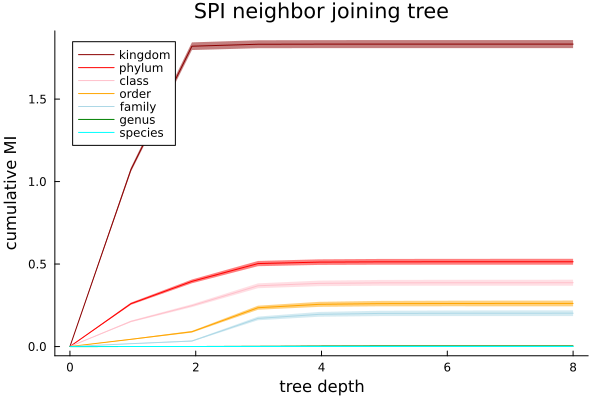

In [6]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), spi_nj_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="SPI neighbor joining tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_SPI_NJ_tree.pdf"))

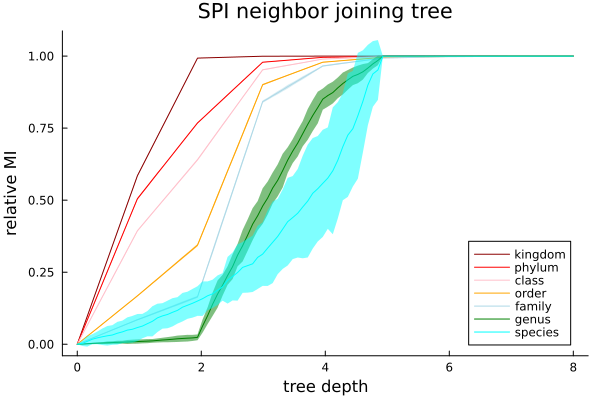

In [7]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree.pdf"))

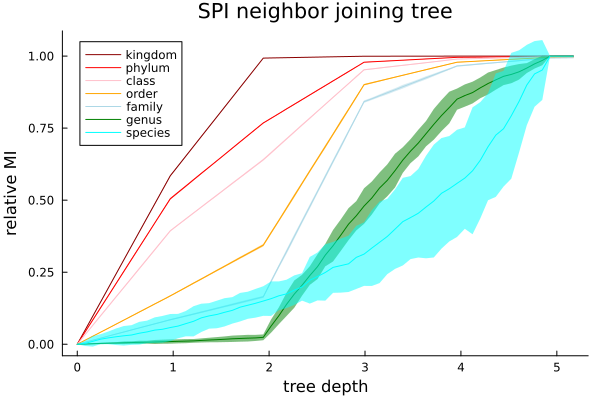

In [13]:
minmax = extrema(mapinternalnodes(network_distance, spi_nj_tree_50pct, spi_nj_tree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

plottingrange = 1:65

pltdf = filter(:taxaID => !=("random"), boot_SPInj_pltdf)
plot(
    cuts[plottingrange],
    reshape(pltdf.cumulative_boot_mean, 100, 7)[plottingrange, :],
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7)[plottingrange, :],
    title="SPI neighbor joining tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [16]:
savefig(joinpath(pdir, "RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis/RelativeMI_SPI_NJ_tree_zoomedintreedepth_treedepth1-65pct.pdf"

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)
pltdf = filter(:taxaID=>!=("random"), banfield_MIdf)
plot(
    cuts,
    cumsum(reshape(pltdf.MI_boot_mean, 100, 7), dims=1),
    ribbon=cumsum(2 * reshape(pltdf.MI_boot_std, 100, 7), dims=1),
    title="Banfield tree",
    ylabel="cumulative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    legend=:topleft,
)

In [ ]:
savefig(joinpath(pdir, "CumulativeMI_Banfield_tree.pdf"))

In [ ]:
minmax = extrema(mapinternalnodes(network_distance, banfieldtree_50pct, banfieldtree_50pct))
cuts = range(0, minmax[2], length=NCUTS)

pltdf = filter(:taxaID => !=("random"), boot_banfield_pltdf)
plot(
    cuts,
    reshape(pltdf.cumulative_boot_mean, 100, 7),
    ribbon=2 * reshape(pltdf.cumulative_boot_std, 100, 7),
    title="Banfield tree",
    ylabel="relative MI", 
    xlabel="tree depth",
    labels=taxonomylevels,
    c=taxarankcolors,
    grid=false,
    # legend=:bot,
)

In [ ]:
savefig(joinpath(pdir, "RelativeMI_Banfield_tree.pdf"))

In [ ]:
plot(spi_nj_tree_50pct)

# Plot full Banfield MSA

In [ ]:
heatmap(replace(permutedims(stack(adf.sequence)), '-' => NaN), yflip = true, framestyle=:none, colorbar=:none, ratio=1)

In [40]:
savefig(joinpath(pdir, "banfield_msa.pdf"))

"/Users/ben/projects/Doran_etal_2022/plots/banfieldtree_analysis/banfield_msa.pdf"

In [24]:
taxonomylevels = ["kingdom", "phylum", "class", "order", "family", "genus", "species"]
lineageroworder = indexin(adf.label, lineagedf.ORGANISM)
rowmeta = lineagedf[lineageroworder, taxonomylevels]
rowmeta[!, "random"] .= sample(["0", "1"], nrow(rowmeta))
IDS = lineagedf.ORGANISM[lineageroworder]
for col in eachcol(rowmeta)
    replace!(col, missing=>"")
end
havelabels = vec(mapslices(r->all(r .!= ""), Matrix(rowmeta), dims=2));

In [40]:
first(adf[havelabels,:], 5).sequence |>
    stack |>
    x -> getindex(permutedims(x), 1:5, 1:5) |>
    x -> mapslices(join, x, dims=2)

5×1 Matrix{String}:
 "MFKK-"
 "-MLKK"
 "MAIHS"
 "MAIHA"
 "MPLNS"

In [39]:
first(adf[havelabels,:], 5).sequence |>
    stack |>
    x -> getindex(permutedims(x), 1:5, lastindex(x,1)-10:lastindex(x,1)) |>
    x -> mapslices(join, x, dims=2)

5×1 Matrix{String}:
 "FKSH--P-VKK"
 "-----------"
 "FKAH-GG-MTR"
 "FKAH-GG-MTR"
 "FKSH--QPGKK"

In [30]:
first(rowmeta[havelabels,:], 5)

Row,kingdom,phylum,class,order,family,genus,species,random
,String15?,String31?,String31?,String?,String?,String?,String,String
1,Bacteria,Chlamydiae,Chlamydiia,Chlamydiales,Chlamydiaceae,Chlamydia,Chlamydia pneumoniae,1
2,Bacteria,Chlamydiae,Chlamydiia,Parachlamydiales,Waddliaceae,Waddlia,Waddlia chondrophila,1
3,Bacteria,Verrucomicrobia,Opitutae,Opitutales,Opitutaceae,Opitutus,Opitutus terrae,1
4,Bacteria,Verrucomicrobia,Opitutae,Opitutales,Opitutaceae,Geminisphaera,Geminisphaera colitermitum,0
5,Bacteria,Verrucomicrobia,Opitutae,Puniceicoccales,Puniceicoccaceae,Coraliomargarita,Coraliomargarita akajimensis,1
